<div style="background-color:#6576FC; color:#19180F; font-size:40px; font-family:Verdana; padding:10px; border: 5px solid #19180F; border-radius: 10px"> CamemBERT </div>
<div style="background-color:#ADB6FB; color:#19180F; font-size:30px; font-family:Verdana; padding:10px; border: 5px solid #19180F; border-radius: 10px"> Architecture Overview </div>
<div style="background-color:#E3E7FF; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F; border-radius: 10px"> CamemBERT is a French language model based on the BERT architecture (Bidirectional Encoder Representations from Transformers). It was created as part of the Transformers library by the Hugging Face team. CamemBERT was trained on a large French corpus and may be used for text categorization, named entity identification, and question answering.<br><br>

CamemBERT's architecture is made up of several main components:<br><br>

Input Embeddings: CamemBERT receives a series of tokens as input. To begin, each token is turned into a vector representation known as an embedding. Each token in the sequence's contextual information is captured by the embeddings.<br><br>

CamemBERT makes use of a stack of Transformer encoder layers. Each encoder layer includes a multi-head self-attention mechanism as well as a position-wise feed-forward neural network. The self-attention mechanism allows each token to attend to other tokens in the sequence, capturing the dependencies between them.<br><br>

Pre-trained Weights: CamemBERT is pre-trained with weights learnt through a language modelling purpose. These weights extract knowledge from a huge French corpus and then apply it to particular downstream tasks.<br><br>

Masked Language Model (MLM): Some tokens in the input sequence are masked during pre-training, and the model is trained to predict the original tokens given the masked tokens. This assignment assists CamemBERT in learning contextual representations that capture the meaning of words in various settings.
<br><br>
Next Sentence Prediction (NSP): Predicting whether two sentences appear consecutively in the original corpus is another pre-training assignment. CamemBERT learns the links between sentences and develops its knowledge of sentence-level semantics by completing this assignment.
<br><br></div>

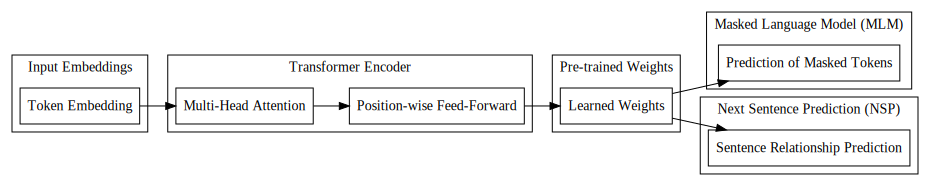

In [1]:
from IPython.display import SVG, display

# Load the SVG file and display it
svg_file = '/kaggle/input/notebook-images/camembert.svg'
display(SVG(filename=svg_file))

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
 Importing modules
    </div>

In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CamembertTokenizer, CamembertForQuestionAnswering, AdamW

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Defining dataset class    </div>

In [3]:
# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.contexts = dataframe['context'].tolist()
        self.questions = dataframe['question'].tolist()
        self.answers = dataframe['answers']

        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.contexts)

    def __getitem__(self, index):
        context = self.contexts[index]
        question = self.questions[index]
        answer = self.answers[index]

        encoding = self.tokenizer.encode_plus(
            question,
            context,
            return_tensors='pt',
            max_length=512,  # Adjust max_length as per your requirements
            padding='max_length',
            truncation=True
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        # Handle string answer
        if isinstance(answer, str):
            answer_start = context.find(answer)
            start_positions = torch.tensor(answer_start, dtype=torch.long)
            end_positions = torch.tensor(answer_start + len(answer), dtype=torch.long)
        else:
            # Handle dictionary answer (if applicable)
            answer_start = answer['answer_start'][0]  # Convert answer_start to scalar integer
            start_positions = torch.tensor(answer_start, dtype=torch.long)
            end_positions = torch.tensor(answer_start + len(answer['text'][0]), dtype=torch.long)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'start_positions': start_positions,
            'end_positions': end_positions
        }

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Reading the dataframe    </div>

In [4]:
dataframe = pd.read_csv('/kaggle/input/unlock-the-power-of-reading-comprehension-with-p/train.csv')

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Initializing the tokenizer and model    </div>

In [5]:
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
model = CamembertForQuestionAnswering.from_pretrained('camembert-base')


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForQuestionAnswering: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForQuestionAnswering were not initialized from the model checkpoint at camembert-base and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Creating train dataset and dataloader    </div>

In [6]:
train_dataset = CustomDataset(dataframe, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Performing sanity check of the dataloader    </div>

In [7]:
for batch in train_dataloader:
    print(batch)
    break

{'input_ids': tensor([[   5, 8965,  102,  ...,    1,    1,    1],
        [   5,  137,  484,  ...,    1,    1,    1],
        [   5, 1034,   11,  ...,    1,    1,    1],
        ...,
        [   5, 7363,  530,  ...,    1,    1,    1],
        [   5, 6753,   13,  ...,    1,    1,    1],
        [   5,  877,   19,  ...,    1,    1,    1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'start_positions': tensor([-1, -1, -1, -1, -1, -1, -1, -1]), 'end_positions': tensor([ 79,  87,  96, 202, 193, 139, 107,  80])}


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Setting device and moving model to device    </div>

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


CamembertForQuestionAnswering(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
  

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Defining optimizer and learning rate scheduler    </div>

In [9]:
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 10

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Checking number of steps per epoch    </div>

In [10]:
print(len(train_dataloader))

480


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Training the model    </div>

In [18]:
from tqdm import tqdm

# Training loop
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for step,batch in tqdm(enumerate(train_dataloader)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            start_positions=start_positions,
            end_positions=end_positions
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        if step%500==0:
            print("Step-{},Loss-{}".format(step,loss.item()))
            break
        
        optimizer.step()

    average_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch+1}/{num_epochs} - Loss: {average_loss:.4f}')

0it [00:18, ?it/s]


Step-0,Loss-4.641871929168701
Epoch 1/10 - Loss: 0.0097


0it [00:16, ?it/s]


Step-0,Loss-4.59449577331543
Epoch 2/10 - Loss: 0.0096


0it [00:16, ?it/s]


Step-0,Loss-4.617000579833984
Epoch 3/10 - Loss: 0.0096


0it [00:17, ?it/s]


Step-0,Loss-4.635828018188477
Epoch 4/10 - Loss: 0.0097


0it [00:17, ?it/s]


Step-0,Loss-4.58721923828125
Epoch 5/10 - Loss: 0.0096


0it [00:17, ?it/s]


Step-0,Loss-4.5945892333984375
Epoch 6/10 - Loss: 0.0096


0it [00:17, ?it/s]


Step-0,Loss-4.846480369567871
Epoch 7/10 - Loss: 0.0101


0it [00:17, ?it/s]


Step-0,Loss-4.552581787109375
Epoch 8/10 - Loss: 0.0095


0it [00:17, ?it/s]


Step-0,Loss-4.567978858947754
Epoch 9/10 - Loss: 0.0095


0it [00:18, ?it/s]

Step-0,Loss-4.566254138946533
Epoch 10/10 - Loss: 0.0095


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Defining the function for evaluation    </div>

In [19]:
def french_question_answering(question, context):
    # Load the tokenizer and model
    tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
    model = CamembertForQuestionAnswering.from_pretrained('camembert-base')

    # Tokenize the question and context
    encoding = tokenizer.encode_plus(
        question,
        context,
        return_tensors='pt',
        max_length=512,
        padding='max_length',
        truncation=True
    )

    # Perform inference
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Get the predicted start and end positions
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits

    # Find the start and end positions with the maximum logits
    start_index = torch.argmax(start_logits)
    end_index = torch.argmax(end_logits)

    # Convert the token IDs to tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze())
    answer = tokenizer.convert_tokens_to_string(tokens[start_index:end_index+1])

    return answer

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌
Evaluating the model    </div>

In [20]:
question = "Qu'est-ce que le Camembert ?"
context = "Le Camembert est un fromage français à pâte molle et à croûte fleurie."

answer = french_question_answering(question, context)
print(answer)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForQuestionAnswering: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing CamembertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForQuestionAnswering were not initialized from the model checkpoint at camembert-base and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

</s>Le Camembert est
